# 🛍️ Retail Demand Forecasting - Baseline Models (Prophet & SARIMA)

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prophet
from prophet import Prophet

# SARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


## 📦 Load or generate dataset

In [2]:

# Load Dataset
# You can replace this with your own dataset
# We'll use a simplified public dataset from a csv or generate synthetic data
try:
    df = pd.read_csv("../data/train.csv", parse_dates=["date"])
except:
    # Generate synthetic time series
    date_rng = pd.date_range(start='2020-01-01', end='2022-01-01', freq='D')
    df = pd.DataFrame(date_rng, columns=['date'])
    df['sales'] = 50 + np.sin(np.linspace(0, 20 * np.pi, len(df))) * 10 + np.random.normal(0, 3, len(df))

df = df[['date', 'sales']]
df.columns = ['ds', 'y']
df.head()


,ds,y
0,2020-01-01,49.219707
1,2020-01-02,50.083888
2,2020-01-03,60.710084
3,2020-01-04,46.457192
4,2020-01-05,54.455678


## 📊 Plot the time series

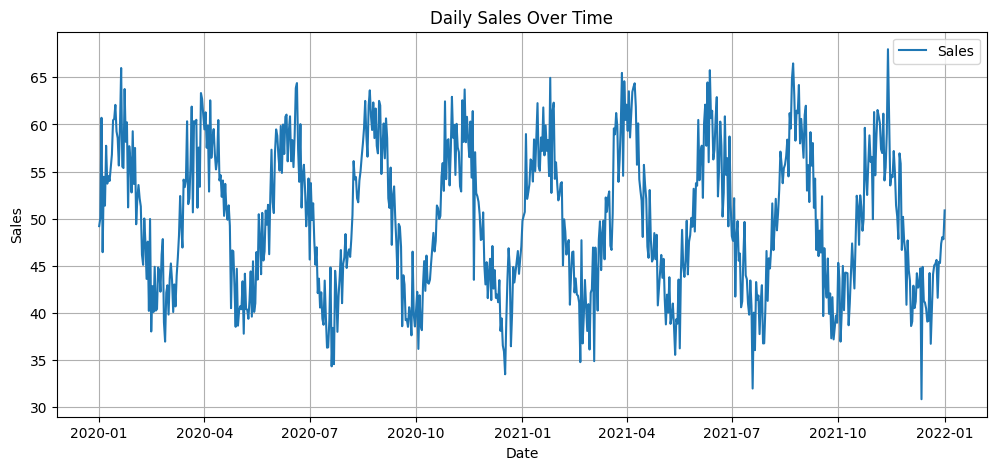

In [3]:

plt.figure(figsize=(12, 5))
plt.plot(df['ds'], df['y'], label='Sales')
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()


## ✂️ Train/Test split

In [5]:

# Split train/test
train = df.iloc[:-60]
test = df.iloc[-60:]


## 🔮 Prophet Forecasting

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp97a0udkn/8ybp45px.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp97a0udkn/7xugn8u0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60316', 'data', 'file=/tmp/tmp97a0udkn/8ybp45px.json', 'init=/tmp/tmp97a0udkn/7xugn8u0.json', 'output', 'file=/tmp/tmp97a0udkn/prophet_model4lgn5ecd/prophet_model-20250717150111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:01:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:01:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training Prophet model...


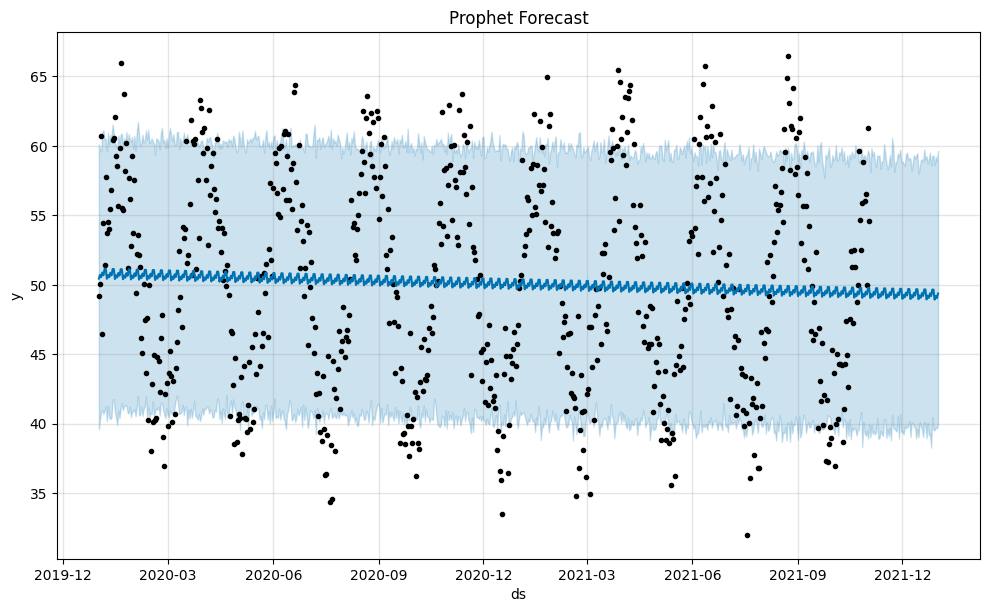

[Prophet] MAE: 6.64, RMSE: 7.70


In [6]:

print("Training Prophet model...")
model_prophet = Prophet()
model_prophet.fit(train)

future = model_prophet.make_future_dataframe(periods=60)
forecast = model_prophet.predict(future)

# Plot forecast
model_prophet.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

# Evaluation
y_true = test['y'].values
y_pred_prophet = forecast.iloc[-60:]['yhat'].values

mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
rmse_prophet = math.sqrt(mean_squared_error(y_true, y_pred_prophet))
print(f"[Prophet] MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")


## 📈 SARIMA Forecasting

In [7]:

print("Training SARIMA model...")
sarima_model = SARIMAX(train['y'], order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = sarima_model.fit(disp=False)

sarima_pred = sarima_fit.forecast(steps=60)
mae_sarima = mean_absolute_error(y_true, sarima_pred)
rmse_sarima = math.sqrt(mean_squared_error(y_true, sarima_pred))

print(f"[SARIMA] MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")


Training SARIMA model...
[SARIMA] MAE: 9.64, RMSE: 11.31



## 📊 Forecast Comparison

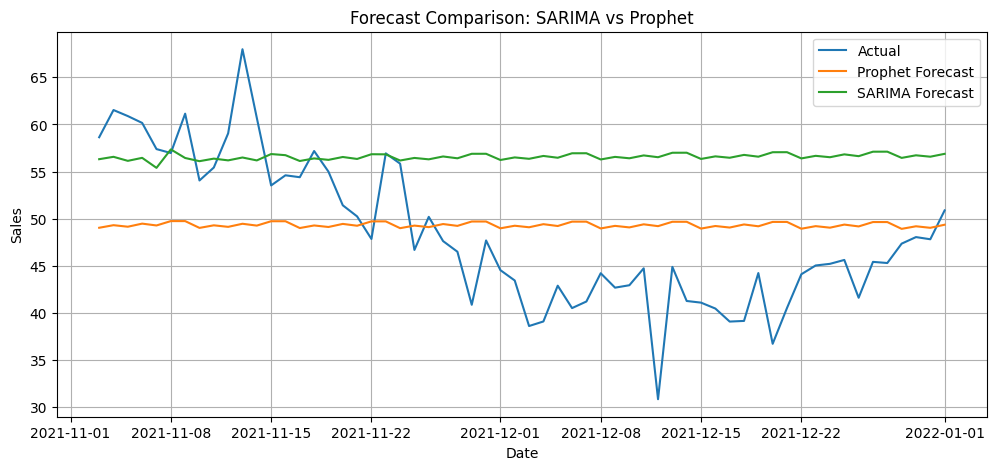

In [9]:

# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(test['ds'], y_true, label='Actual')
plt.plot(test['ds'], y_pred_prophet, label='Prophet Forecast')
plt.plot(test['ds'], sarima_pred, label='SARIMA Forecast')
plt.title("Forecast Comparison: SARIMA vs Prophet")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.savefig("forecast_comparison_lstm_timesfm.png", dpi=300, bbox_inches='tight')
plt.show()
